In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
from tensorflow.keras.regularizers import l2

Número de fotos Parasitized: 6570
Número de fotos Uninfected: 6582


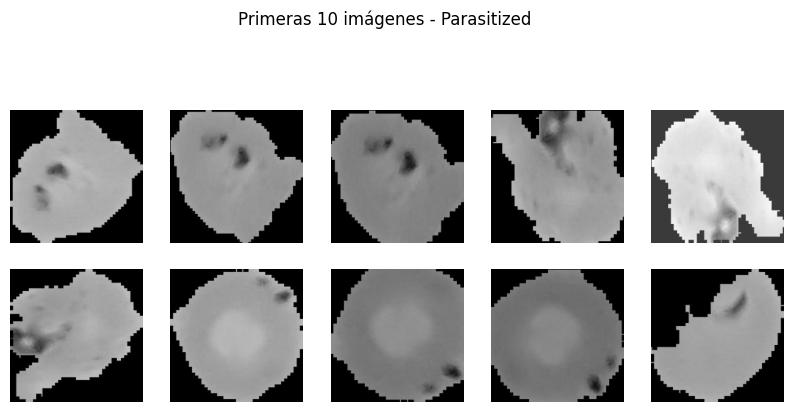

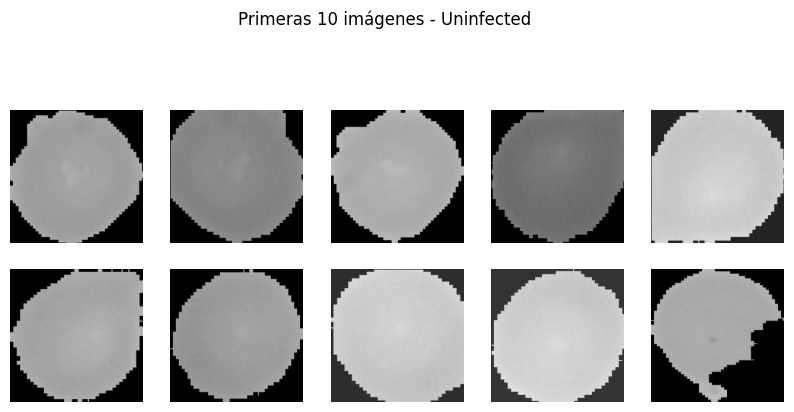

In [3]:
# Define las rutas a las carpetas
train_dir = r'C:\Users\lenovo\Desktop\Malaria Detection\Malaria Detector\Data\Fotos\train'
parasitized_dir = os.path.join(train_dir, 'Parasitized')
uninfected_dir = os.path.join(train_dir, 'Uninfected')

# Contamos número de imágenes por carpeta
parasitized_count = len(os.listdir(parasitized_dir))
uninfected_count = len(os.listdir(uninfected_dir))

print(f'Número de fotos Parasitized: {parasitized_count}')
print(f'Número de fotos Uninfected: {uninfected_count}')

# Función para mostrar las primeras 10 imágenes de una categoría
def show_images(category_dir, category_name):
    images = os.listdir(category_dir)[:10]  # Obtener las primeras 10 imágenes
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Primeras 10 imágenes - {category_name}')
    plt.show()

# Mostrar las primeras 10 imágenes de cada categoría
show_images(parasitized_dir, 'Parasitized')
show_images(uninfected_dir, 'Uninfected')

In [4]:
# Define las rutas a las carpetas
train_dir = r'C:\Users\lenovo\Desktop\Malaria Detection\Malaria Detector\Data\Fotos\train'
validation_dir = r'C:\Users\lenovo\Desktop\Malaria Detection\Malaria Detector\Data\Fotos\valid'
test_dir = r'C:\Users\lenovo\Desktop\Malaria Detection\Malaria Detector\Data\Fotos\test'

In [5]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Datagen para preprocesar las imagénes cargadas 
train_scaled_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # Las imagenes se redimensionan a 224 x 224 pixeles mayor rendimiento para la red MobileNetv2
    batch_size=64,shuffle=True, # Se cargan en lotes de 64 / se barajan aleatoriamente en cada epoca 
    class_mode='sparse' # Las etiquetas se devuelven como enteros otra opcion "Categorical"
)

test_scaled_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=64,shuffle=False,
    class_mode='sparse'
)

valid_scaled_data = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,shuffle=True,
    class_mode='sparse'
)


Found 13152 images belonging to 2 classes.
Found 626 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.


In [6]:
train_scaled_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [7]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

# Construccion de modelo red neuronal utilizando el modelo preentrenado de MobileNetv2 como base
# Añadiendo capas personalizadas para adaptarlo a una tarea especifica

# Definir el tensor de entrada especifica la forma de entrada de las imágenes de entrada (224 x 224) 
input_tensor = Input(shape=(224, 224, 3))

# Cargar el modelo pre-entrenado MobileNetV2 sin la capa superior y con los pesos preentrenados de imagenet.
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

# Congelar las capas pre-entrenadas
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas encima del modelo base
x = base_model.output
x = GlobalAveragePooling2D()(x) #
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
output = Dense(2, activation='softmax')(x) # La capa de salida tiene dos unidades (clasificación binaria)

# Defiir el nuevo modelo
model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo 
model.summary()

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_11476\2585355772.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,396,386 (9.14 MB)

 Trainable params: 138,402 (540.63 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
train_scaled_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [9]:
# Entrenar el modelo
from tensorflow.keras.callbacks import EarlyStopping

# Earlystopping para detener es entrenamiento y evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, # Si no hay mejora después de 3 epocas se detiene el entrenamiento 
                               restore_best_weights=True)

history = model.fit(train_scaled_data ,batch_size=64,epochs=100,
                verbose=1,
                validation_data=valid_scaled_data,
                callbacks=[early_stopping])

Epoch 1/100


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 1078s 5s/step - accuracy: 0.7865 - loss: 0.4382 - val_accuracy: 0.8563 - val_loss: 0.3111
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 814s 4s/step - accuracy: 0.8686 - loss: 0.3237 - val_accuracy: 0.8739 - val_loss: 0.3068
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.8768 - loss: 0.3006 - val_accuracy: 0.8795 - val_loss: 0.2826
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 695s 3s/step - accuracy: 0.8769 - loss: 0.2954 - val_accuracy: 0.8859 - val_loss: 0.2806
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - accuracy: 0.8776 - loss: 0.2928 - val_accuracy: 0.8819 - val_loss: 0.2822
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 635s 3s/step - accuracy: 0.8878 - loss: 0.2792 - val_accuracy: 0.8851 - val_loss: 0.2810
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.8862 - loss: 0.2820 - val_accuracy: 0.8843 - val_loss: 0.2813


In [10]:
# # Evaluar el modelo en los datos de entrenamiento
loss,acc = model.evaluate(train_scaled_data)
print("Pérdida en los datos de entrenamiento:",loss)
print("Exactitud en los datos de entrenamiento:",acc)

# Evaluar el modelo en los datos de prueba
loss1,acc1 = model.evaluate(test_scaled_data)

print("Pérdida en los datos de prueba:",loss1)
print("Exactitud en los datos de prueba:",acc1)

206/206 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.8875 - loss: 0.2721
Pérdida en los datos de entrenamiento: 0.27813664078712463
Exactitud en los datos de entrenamiento: 0.8872414827346802
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8767 - loss: 0.2690
Pérdida en los datos de prueba: 0.26472872495651245
Exactitud en los datos de prueba: 0.894568681716919


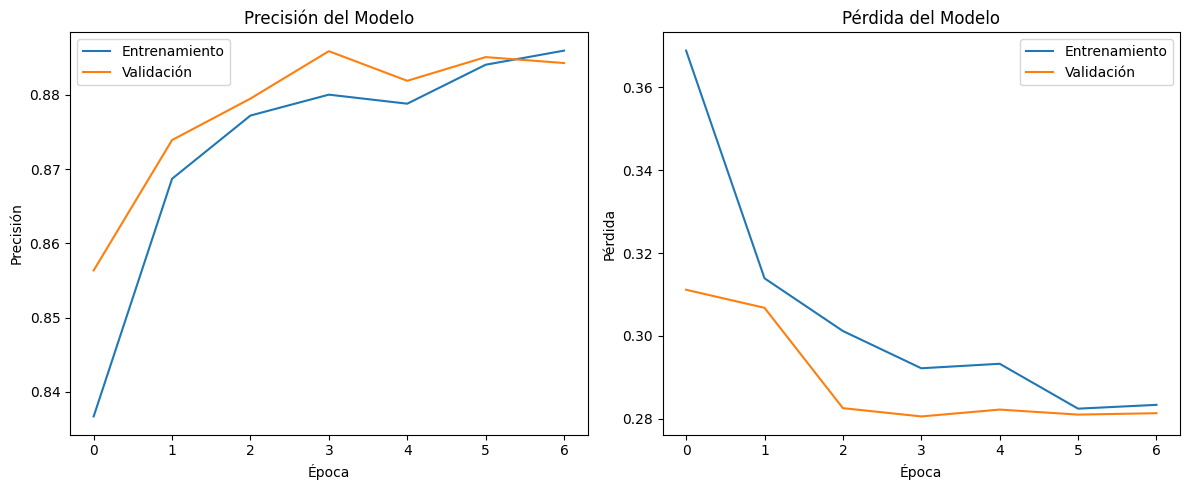

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
train_scaled_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


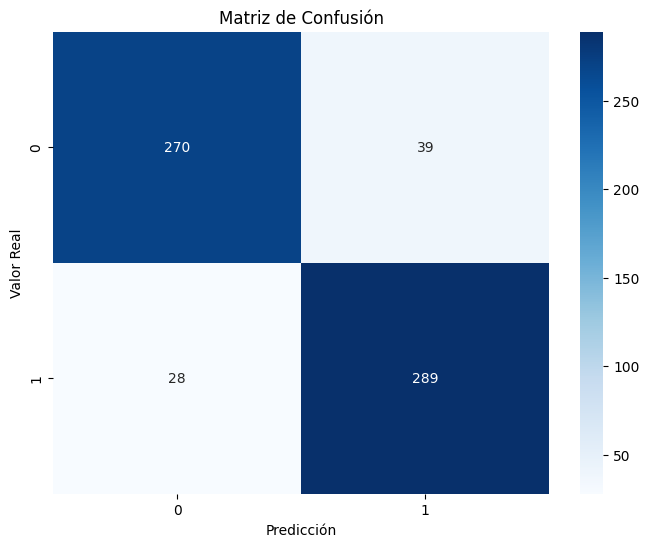

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar predicciones
y_pred = model.predict(test_scaled_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_scaled_data.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

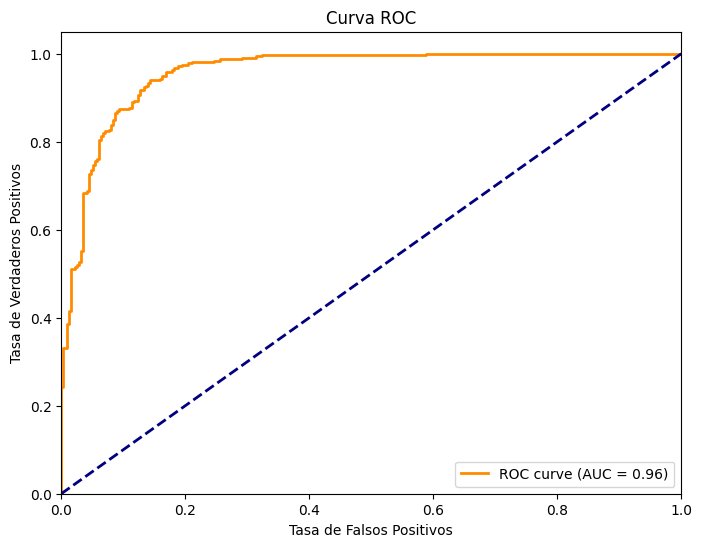

In [19]:
from sklearn.metrics import roc_curve, auc

# Asumiendo que la clase positiva es la 0 (infectada)
y_pred_proba = y_pred[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

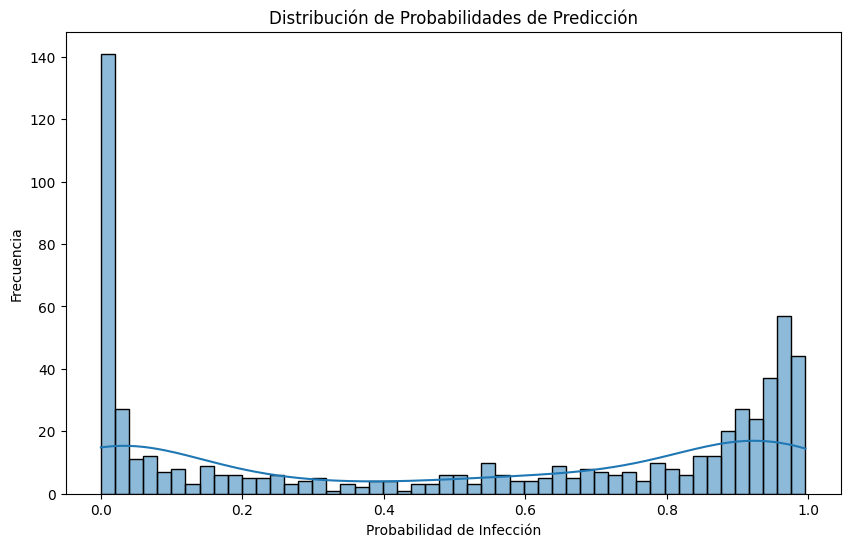

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred[:, 1], kde=True, bins=50)
plt.title('Distribución de Probabilidades de Predicción')
plt.xlabel('Probabilidad de Infección')
plt.ylabel('Frecuencia')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


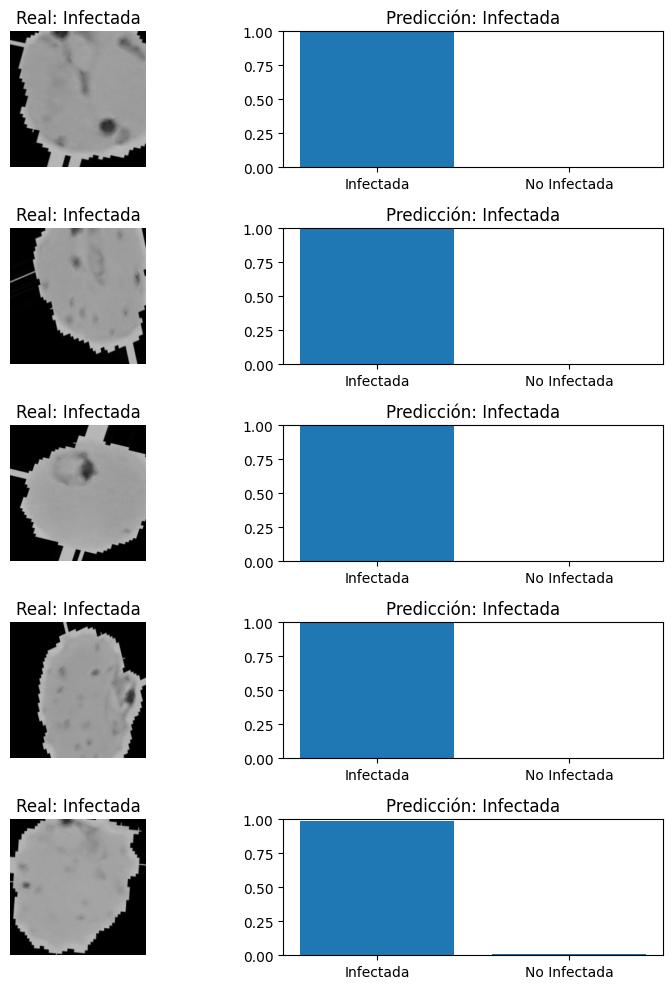

In [16]:
def plot_predictions(model, data, num_images=5):
    images, labels = next(data)
    predictions = model.predict(images)
    
    plt.figure(figsize=(12, 2*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i*3+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"Real: {'No Infectada' if labels[i] == 1 else 'Infectada'}")
        
        plt.subplot(num_images, 3, i*3+2)
        plt.bar(['Infectada', 'No Infectada'], predictions[i])
        plt.ylim(0, 1)
        plt.title(f"Predicción: {'No Infectada' if np.argmax(predictions[i]) == 1 else 'Infectada'}")
        
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_scaled_data)

In [22]:
model.save('mi_modelo.h5')